# Setup

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None, filename="plot" ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # check if there are more than two series in x and y to plot
    if (type(x) is tuple) and (type(y) is tuple):

        # Loop over the x elements
        for x_curr, y_curr in zip(x,y):
            
            # Plot the x and current y values
            plt.plot(x_curr[start:end], y_curr[start:end], format)
    
    # Check if there are more than two series in y to plot
    elif type(y) is tuple:

        # Loop over the y elements
        for y_curr in y:
        
            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)

    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # save the plot
    plt.savefig(f"./plots/{filename}.png", format = "png")
    
    # Draw the graph on screen
    plt.show()

## Parameters

In [3]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Download and Preview the Dataset

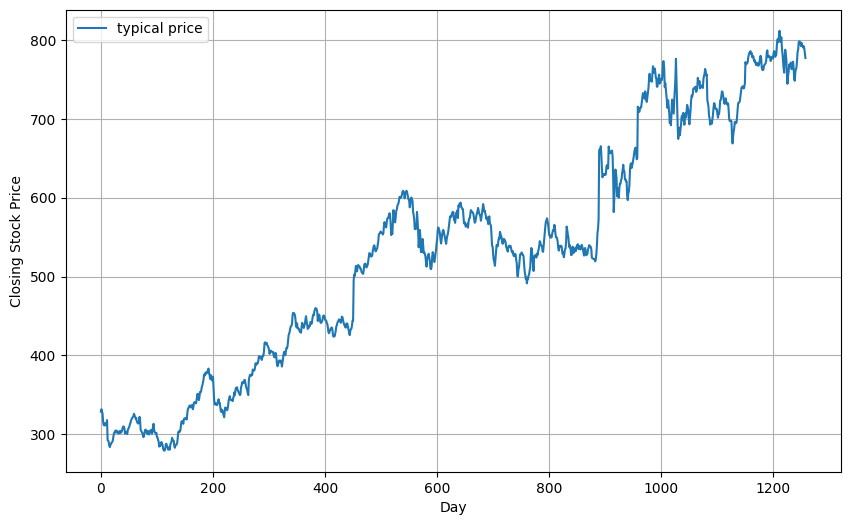

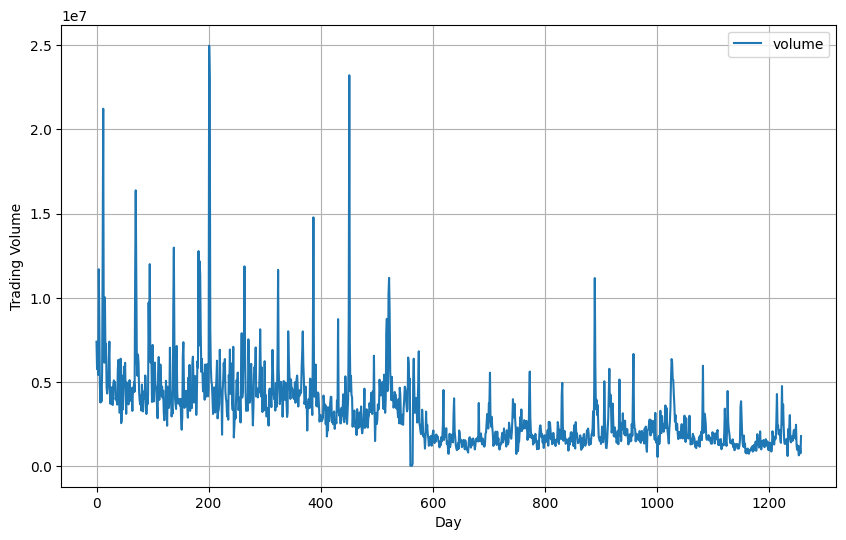

In [4]:
# Initialize lists
time_step = []
open_price = []
close_price = []
high_price = []
low_price = []
volume = []
date = []

# Open CSV file
with open('./Google_Stock_Price_Train.csv') as csvfile:
  
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')
    
    # Skip the first line
    next(reader)
    
    # Append row and sunspot number to lists
    for row in reader:
        open_price.append(float(row[1].replace(',','')))
        close_price.append(float(row[4].replace(',','')))
        high_price.append(float(row[2].replace(',','')))
        low_price.append(float(row[3].replace(',','')))
        volume.append(float(row[5].replace(',','')))
        date.append(datetime.strptime(row[0], "%m/%d/%Y"))

# create the time step
time_step = list(range(len(open_price)))

before_transform = (open_price[:600].copy(), close_price[:600].copy(), high_price[:600].copy(), low_price[:600].copy())
# transform the closing price
close_price = [p/2 for p in close_price[:560]] + close_price[560:]
after_transform = (open_price[:600].copy(), close_price[:600].copy(), high_price[:600].copy(), low_price[:600].copy())

# Convert lists to numpy arrays
open_price = np.array(open_price)
close_price = np.array(close_price)
high_price = np.array(high_price)
low_price = np.array(low_price)
volume = np.array(volume)
time_step = np.array(time_step).reshape(open_price.shape)
average_price = (open_price+high_price+low_price+close_price)/4

# Preview the data
plot_series(time_step, average_price, xlabel='Day', ylabel='Closing Stock Price', legend=["typical price"])
plot_series(time_step, volume, xlabel='Day', ylabel='Trading Volume', legend=["volume"])

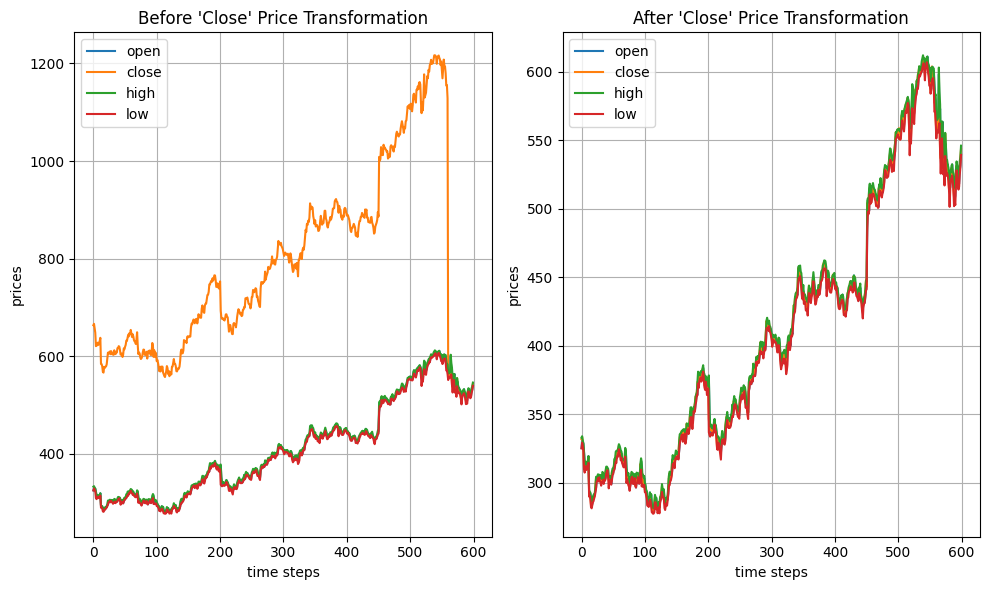

In [5]:
# plot comparison between transformed and untransformed data

# Setup dimensions of the graph figure
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
  
# Plot prices before transformation
for y_curr in before_transform:
    axs[0].plot(time_step[:600], y_curr, "-")

# Plot prices before transformation
for y_curr in after_transform:
    axs[1].plot(time_step[:600], y_curr, "-")

# Label the x-axis
axs[0].set_xlabel("time steps")
axs[1].set_xlabel("time steps")

# Label the y-axis
axs[0].set_ylabel("prices")
axs[1].set_ylabel("prices")

# Set the legend
axs[0].legend(["open","close","high","low"])
axs[1].legend(["open","close","high","low"])

# Set the title
axs[0].set_title("Before 'Close' Price Transformation")
axs[1].set_title("After 'Close' Price Transformation")

# Overlay a grid on the graph
axs[0].grid(True)
axs[1].grid(True)

# Draw the graph on screen
plt.tight_layout()
plt.show()

# save the plot
fig.savefig('./plots/transformation_comparison.png', format='png')

In [6]:
treasury_date = []
treasury_rate = []

with open('./daily-treasury-rates.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    treasury_date.append(datetime.strptime(row[0], "%m/%d/%Y"))
    treasury_rate.append(float(row[2].replace(',','')))

treasury_date.reverse()
treasury_rate.reverse()

In [7]:
# make sure data from both sources are the same dates
missing_dates = list(set(date)-set(treasury_date))
print(f"There are {len(missing_dates)} dates in stock price date which are not in treasury date")
missing_indicies = [col_index for col_index, value in enumerate(date) if value in missing_dates]
date = [item for index, item in enumerate(date) if index not in missing_indicies]
open_price = np.delete(open_price, missing_indicies)
close_price = np.delete(close_price, missing_indicies)
high_price = np.delete(high_price, missing_indicies)
low_price = np.delete(low_price, missing_indicies)
volume = np.delete(volume, missing_indicies)
time_step = np.array([range(open_price.shape[0])]).reshape(open_price.shape)
average_price = (open_price+high_price+low_price+close_price)/4

missing_dates2 = list(set(treasury_date)-set(date))
print(f"There are {len(missing_dates2)} dates in treasury price date which are not in stock date")
missing_indicies2 = [col_index for col_index, value in enumerate(treasury_date) if value in missing_dates2]
treasury_date = [item for index, item in enumerate(treasury_date) if index not in missing_indicies2]
treasury_rate = np.array([item for index, item in enumerate(treasury_rate) if index not in missing_indicies2])
print(f"Final timesteps: {len(treasury_date)} dates")

There are 10 dates in stock price date which are not in treasury date
There are 3 dates in treasury price date which are not in stock date
Final timesteps: 1248 dates


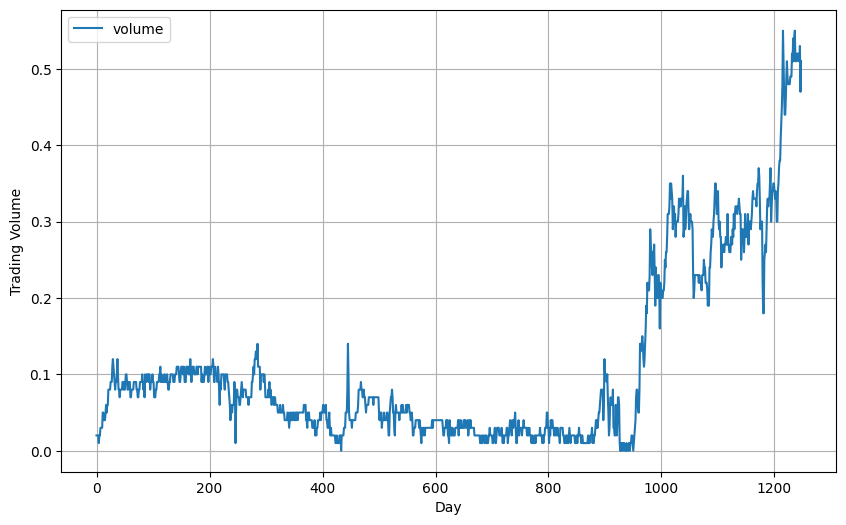

In [8]:
plot_series(time_step, treasury_rate, xlabel='Day', ylabel='Trading Volume', legend=["volume"])

# Model 1 Univariate Analysis using Typical Price to Predict Typical Price

## Split the Dataset

In [9]:
# Define the split time
train_val_test_proportion = (0.8, 0.1, 0.1)
train_split = int(train_val_test_proportion[0]*len(average_price))
val_split = int((train_val_test_proportion[0]+train_val_test_proportion[1])*len(average_price)/sum(train_val_test_proportion))

For Univariate analaysis, we will use data from only from one variable, which is the average price.

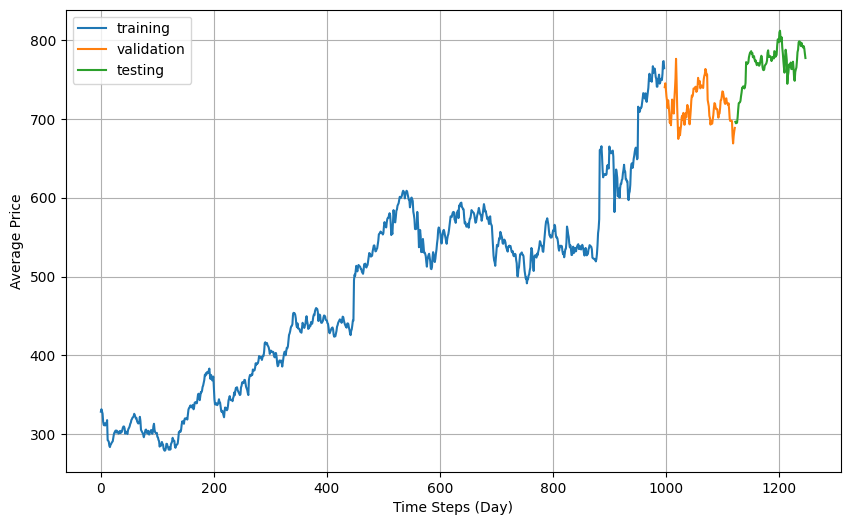

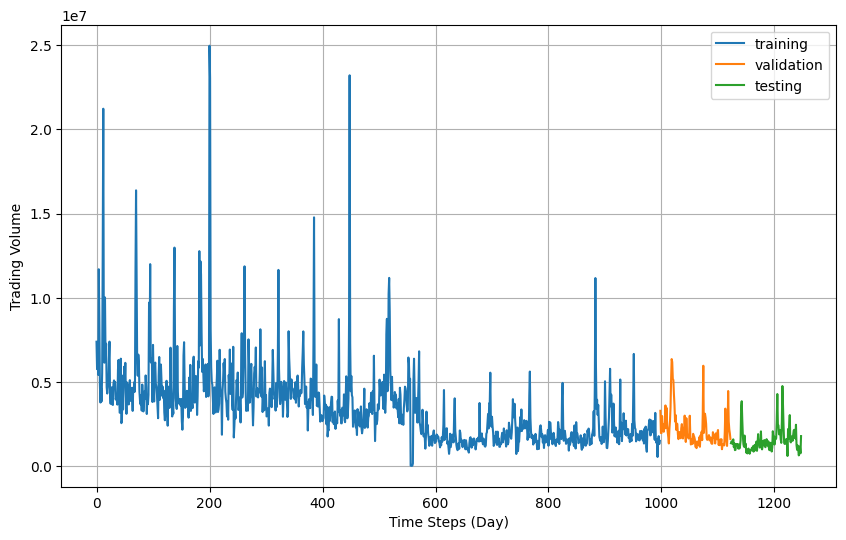

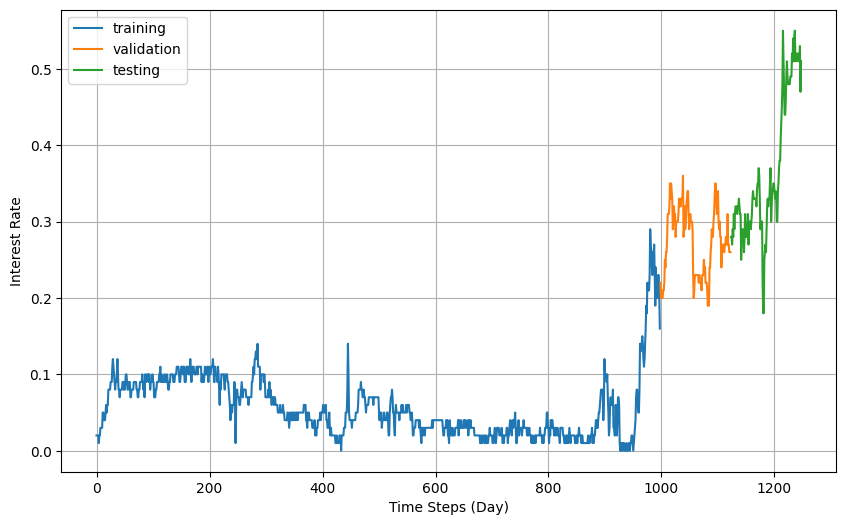

In [10]:
# Get the train set 
time_train = time_step[:train_split]
x_train = average_price[:train_split]
volume_train = volume[:train_split]
t_rate_train = treasury_rate[:train_split]

# Get the validation set
time_valid = time_step[train_split:val_split]
x_valid = average_price[train_split:val_split]
volume_valid = volume[train_split:val_split]
t_rate_valid = treasury_rate[train_split:val_split]

# Get the test set
time_test = time_step[val_split:]
x_test = average_price[val_split:]
volume_test = volume[val_split:]
t_rate_test = treasury_rate[val_split:]

plot_series((time_train, time_valid, time_test), (x_train, x_valid, x_test), 
            xlabel='Time Steps (Day)', ylabel='Average Price', 
            legend=(["training","validation","testing"]), filename="average_price_split")

plot_series((time_train, time_valid, time_test), (volume_train, volume_valid, volume_test), 
            xlabel='Time Steps (Day)', ylabel='Trading Volume', 
            legend=(["training","validation","testing"]), filename="volume_split")

plot_series((time_train, time_valid, time_test), (t_rate_train, t_rate_valid, t_rate_test), 
            xlabel='Time Steps (Day)', ylabel='Interest Rate', 
            legend=(["training","validation","testing"]), filename="interest_split")

## Prepare Features and Labels

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers (this is the only difference with multivariate)
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [12]:
# Generate the training dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Generate the validation dataset windows
val_series = average_price[val_split-train_split-window_size:train_split-1]
val_set = windowed_dataset(val_series, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [13]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1),
])

 # Print the model summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,849 (93.16 KB)

 Trainable params: 23,849 (93.16 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

In [14]:
# Get initial weights
init_weights = model.get_weights()

In [15]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 489.7640 - learning_rate: 1.0000e-08
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 1.1220e-08
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 1.2589e-08
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 1.4125e-08
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 1.5849e-08
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 1.7783e-08
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 1.9953e-08
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 2.2387e-08
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 2.5119e-08
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489.7640 - learning_rate: 2.8184e-08
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━

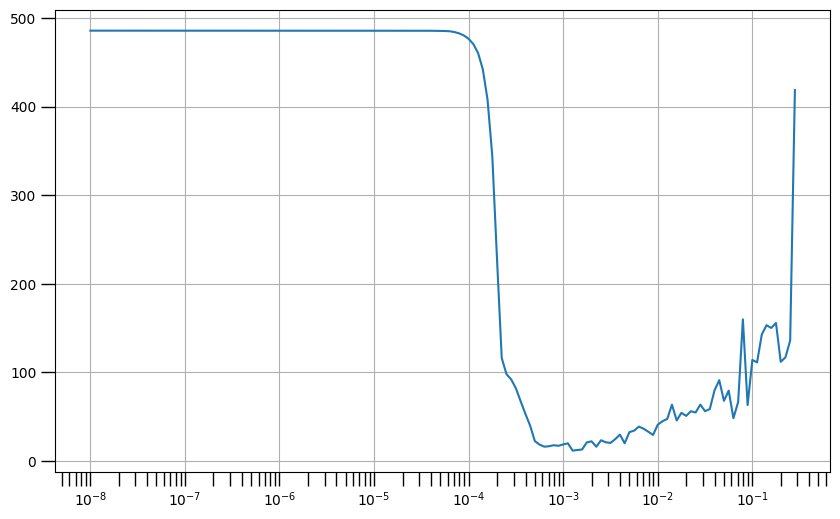

In [16]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(150) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

## Train the Model

In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [18]:
# Set the learning rate
learning_rate = 3e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
# Train the model
history = model.fit(train_set,epochs=150,validation_data=val_set)

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 489.7603 - mae: 490.2603 - val_loss: 505.3910 - val_mae: 505.8910
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 489.7399 - mae: 490.2399 - val_loss: 505.3528 - val_mae: 505.8528
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 489.6868 - mae: 490.1868 - val_loss: 505.2267 - val_mae: 505.7267
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 489.5193 - mae: 490.0193 - val_loss: 504.8898 - val_mae: 505.3898
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 488.9446 - mae: 489.4446 - val_loss: 503.1084 - val_mae: 503.6084
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 486.6589 - mae: 487.1589 - val_loss: 498.9900 - val_mae: 499.4900
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 481.6129 - mae: 482.1129 - val_loss: 490.7431 - val_mae: 491.2431
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 471.9427 - mae: 472.4427 - val_loss: 475.7609 - val_mae: 476.2609

You can visualize the training and see if the loss and MAE are still trending down.

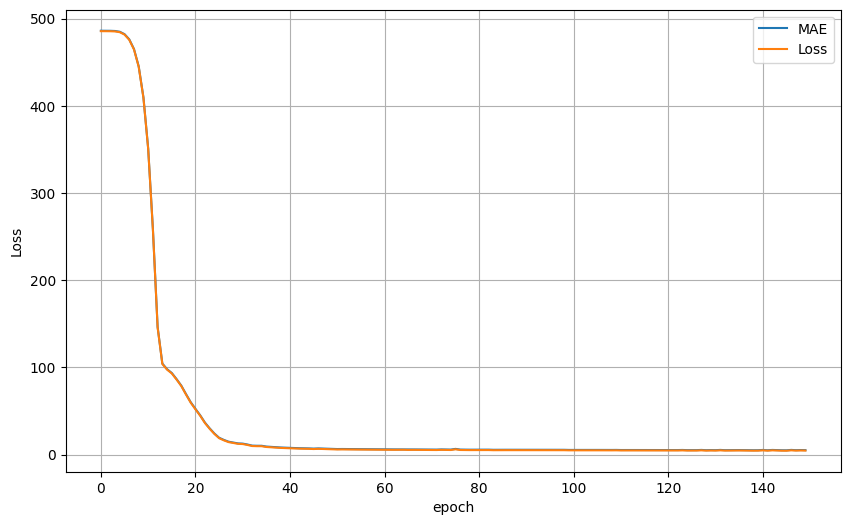

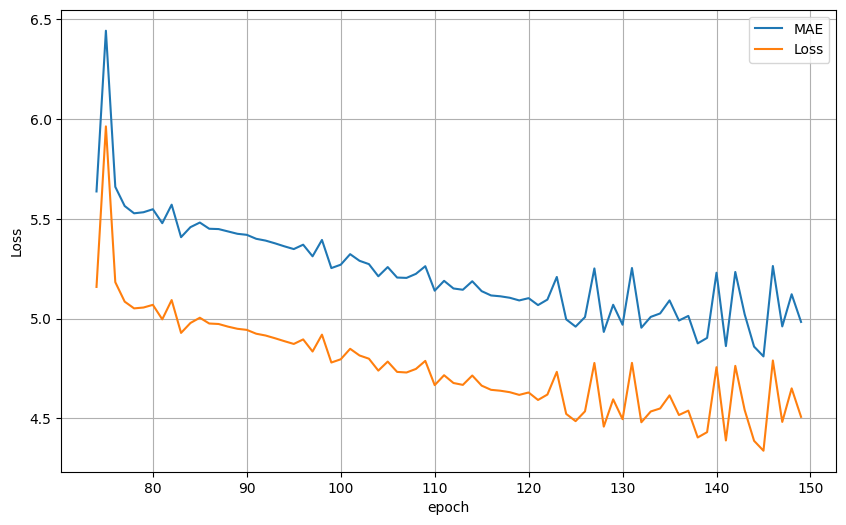

In [20]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss),
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss'], filename="model1_loss"
    )

# Only plot the last 50% of the epochs
zoom_split = int(epochs[-1] * 0.5)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss'], filename="model1_loss_zoom"
    )

## Model Prediction

In [21]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

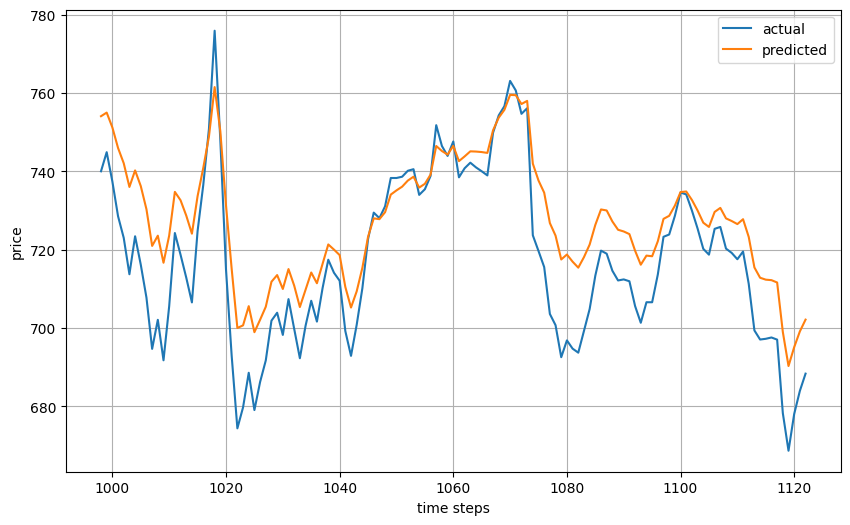

In [22]:
# Reduce the original series
forecast_series = average_price[train_split-window_size+1:val_split]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), xlabel="time steps", ylabel="price", legend=["actual", "predicted"], filename="model1_output_valid")

In [23]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

10.628196


## Test

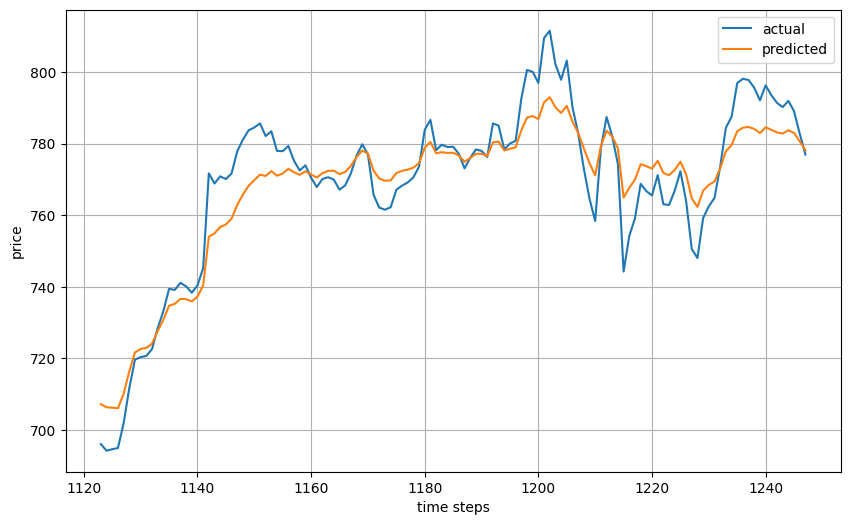

In [24]:
# Reduce the original series
forecast_series = average_price[val_split-window_size+1:]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_test, (x_test, results), xlabel="time steps", ylabel="price", legend=["actual", "predicted"], filename="model1_output_test")

In [25]:
# Compute the MAE
print(tf.keras.metrics.mae(x_test, results).numpy())

6.645759


In [26]:
def windowed_dataset_4(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers (this is the only difference with multivariate)
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 10, shift=10, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-10], window[-10:]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [27]:
# Generate the training dataset windows
train_set = windowed_dataset_4(x_train, window_size, batch_size, shuffle_buffer_size)

# Generate the validation dataset windows
val_series = average_price[val_split-train_split-window_size:train_split-1]
val_set = windowed_dataset_4(val_series, window_size, batch_size, shuffle_buffer_size)

In [28]:
a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
print(a[:-10])
print(a[-10:])

[1, 2, 3, 4, 5, 6]
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [29]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model_4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
])

 # Print the model summary 
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,834 (93.10 KB)

 Trainable params: 23,834 (93.10 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Get initial weights
init_weights_4 = model_4.get_weights()

In [31]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_4.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history_4 = model_4.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150


InvalidArgumentError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_16/1721461446.py", line 12, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 116, in one_step_on_iterator

Detected at node IteratorGetNext defined at (most recent call last):
  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_16/1721461446.py", line 12, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 116, in one_step_on_iterator

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [21,1] and element 1 had shape [0,1].
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [21,1] and element 1 had shape [0,1].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_51573]

# Model 2: Multivariate Analysis using Typical Price, Volume and Interest Rate to Predict Typical Price

In [32]:
data_table = np.hstack((average_price[:, np.newaxis], treasury_rate[:, np.newaxis], volume[:, np.newaxis]))
data_table.shape

(1248, 3)

## Split Datasets

In [33]:
# Get the train set 
time_train = time_step[:train_split]
data_train = data_table[:train_split]

# Get the validation set
time_valid = time_step[train_split:val_split]
data_valid = data_table[train_split:val_split]

# Get the test set
time_test = time_step[val_split:]
data_test = data_table[val_split:]

print(f"training data size: {data_train.shape}")
print(f"validation data size: {data_valid.shape}")
print(f"testing data size: {data_test.shape}")

training data size: (998, 3)
validation data size: (125, 3)
testing data size: (125, 3)


In [34]:
# standardise training data
avg_price_mean = np.mean(data_train[:,0])
avg_price_sd = np.std(data_train[:,0])

t_rate_mean = np.mean(data_train[:,1])
t_rate_sd = np.std(data_train[:,1])

volume_mean = np.mean(data_train[:,2])
volume_sd = np.std(data_train[:,2])

means = np.hstack((avg_price_mean, t_rate_mean, volume_mean)).reshape(1,3)
sds = np.hstack((avg_price_sd, t_rate_sd, volume_sd)).reshape(1,3)

data_train_standard = (data_train-means)/sds
data_valid_standard = (data_valid-means)/sds
data_test_standard = (data_test-means)/sds
data_table_standard = (data_table-means)/sds

## Prepare Features and Labels

In [35]:
def windowed_dataset_2(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1][0])) # only take average price as the label

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [36]:
# Generate the training dataset windows
train_set = windowed_dataset_2(data_train_standard, window_size, batch_size, shuffle_buffer_size)

# Generate the validation dataset windows
val_series = data_table_standard[val_split-train_split-window_size:train_split-1]
val_set = windowed_dataset_2(val_series, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [37]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model_2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1),
])

 # Print the model summary 
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,121 (367.66 KB)

 Trainable params: 94,121 (367.66 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

In [38]:
# Get initial weights
init_weights_2 = model_2.get_weights()

In [39]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history_2 = model_2.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4305 - learning_rate: 1.0000e-08
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 1.1220e-08
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 1.2589e-08
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 1.4125e-08
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 1.5849e-08
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 1.7783e-08
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 1.9953e-08
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 2.2387e-08
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 2.5119e-08
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4305 - learning_rate: 2.8184e-08
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss:

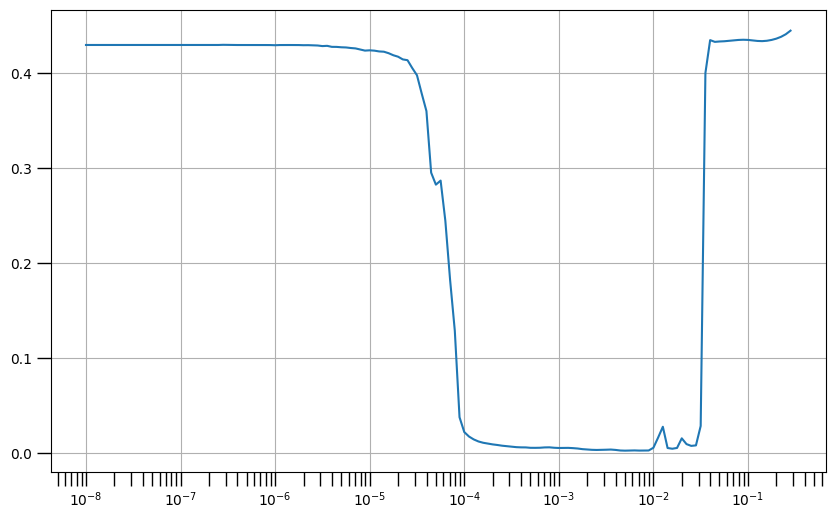

In [40]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(150) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_2.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')


## Train the Model

In [41]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_2.set_weights(init_weights_2)

In [42]:
# Set the learning rate
learning_rate = 1e-3

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model_2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [43]:
# Train the model
history_2 = model_2.fit(train_set, epochs=80, validation_data=val_set)

Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4171 - mae: 0.8261 - val_loss: 0.1687 - val_mae: 0.4333
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2525 - mae: 0.5355 - val_loss: 0.1335 - val_mae: 0.3523
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2246 - mae: 0.4764 - val_loss: 0.1223 - val_mae: 0.3200
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2119 - mae: 0.4535 - val_loss: 0.1137 - val_mae: 0.3032
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2002 - mae: 0.4341 - val_loss: 0.1059 - val_mae: 0.2864
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1900 - mae: 0.4179 - val_loss: 0.0990 - val_mae: 0.2734
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1804 - mae: 0.4031 - val_loss: 0.0925 - val_mae: 0.2597
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1714 - mae: 0.3886 - val_loss: 0.0876 - val_mae: 0.2500
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1638 - mae:

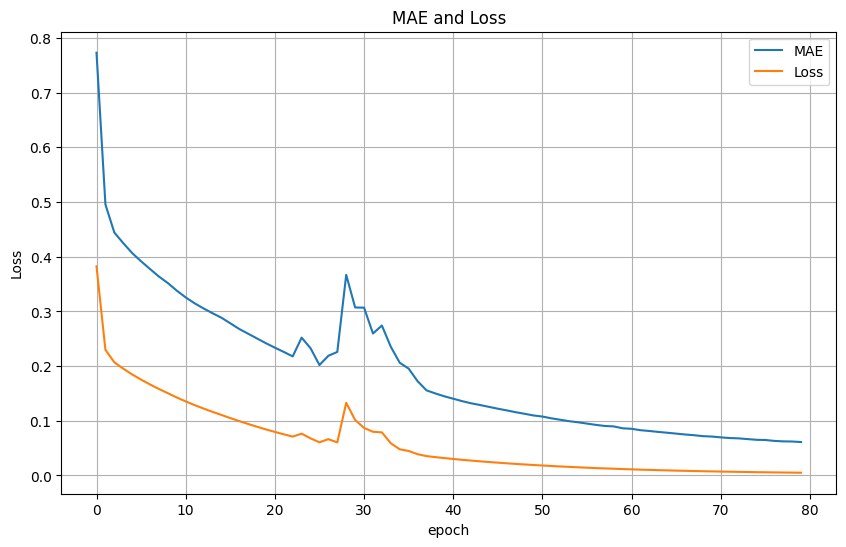

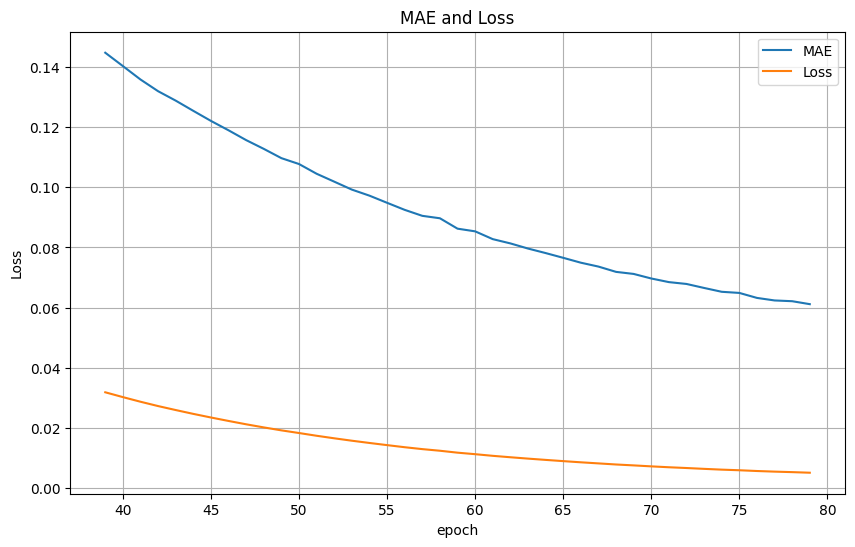

In [44]:
# Get mae and loss from history log
mae = history_2.history['mae']
loss = history_2.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss'], filename="model2_loss"
    )

# Only plot the last 50% of the epochs
zoom_split = int(epochs[-1] * 0.5)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss'], filename="model2_loss_zoom"
    )

## Validation

In [45]:
def model_forecast_2(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

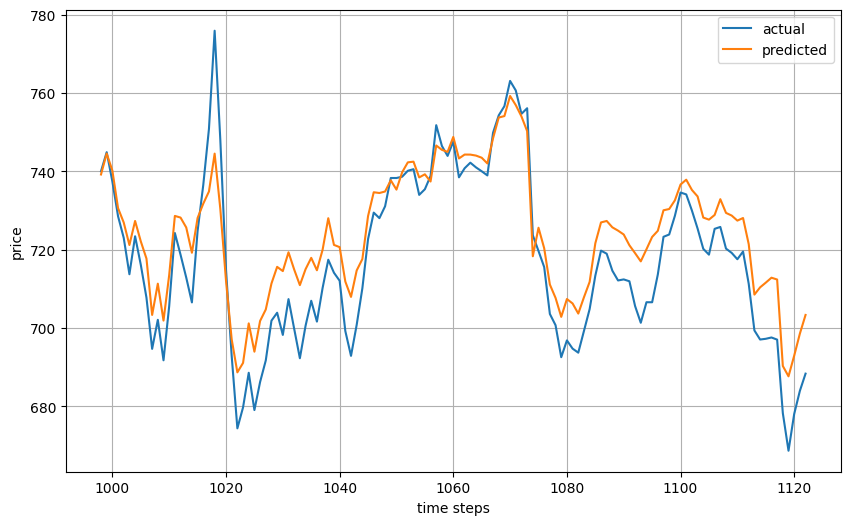

In [46]:
# Reduce the original series
forecast_data = data_table_standard[train_split-window_size+1:val_split]

# Use helper function to generate predictions
forecast = model_forecast_2(model_2, forecast_data, window_size, batch_size)

forecasted_avg_price = (forecast[:,0] * avg_price_sd) + avg_price_mean
actual_avg_price_valid = data_valid[:,0]

# Plot the open price
plot_series(time_valid, (actual_avg_price_valid, forecasted_avg_price), xlabel="time steps", ylabel="price", legend=["actual", "predicted"], filename="model2_valid")

In [47]:
tf.keras.losses.MAE(actual_avg_price_valid, forecasted_avg_price).numpy()

8.393355

## Testing

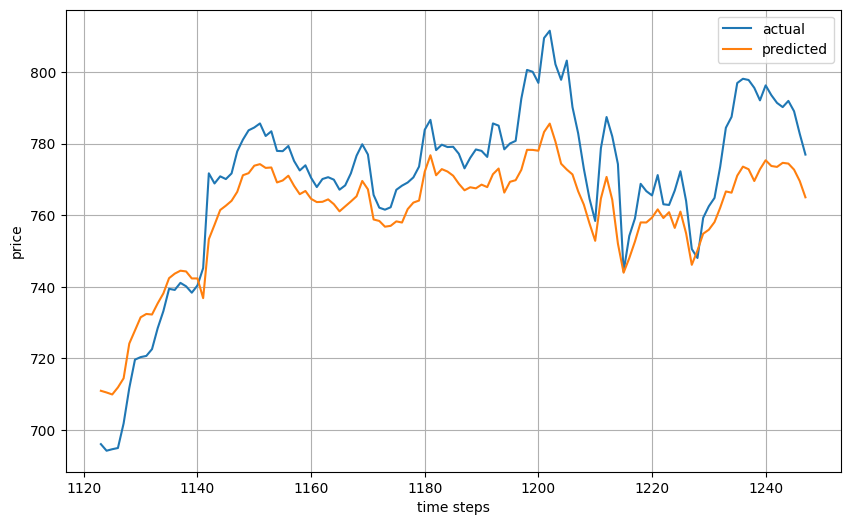

In [48]:
# Reduce the original series
forecast_data = data_table_standard[val_split-window_size+1:]

# Use helper function to generate predictions
forecasted_test = model_forecast_2(model_2, forecast_data, window_size, batch_size)

forecasted_avg_price_test = (forecasted_test[:,0] * avg_price_sd) + avg_price_mean
actual_avg_price_test = data_test[:,0]

# Plot the open price
plot_series(time_test, (actual_avg_price_test, forecasted_avg_price_test), xlabel="time steps", ylabel="price", legend=["actual", "predicted"], filename="model2_test")

In [49]:
tf.keras.losses.MAE(actual_avg_price_test, forecasted_avg_price_test).numpy()

11.2274685

In [50]:
data_table = np.hstack((open_price[:, np.newaxis], close_price[:, np.newaxis], high_price[:, np.newaxis], low_price[:, np.newaxis], volume[:, np.newaxis]))
data_table.shape

(1248, 5)

In [53]:
def multivariate_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [54]:
# Generate the training dataset windows
multivariate_train_set = multivariate_windowed_dataset(data_train_standard, window_size, batch_size, shuffle_buffer_size)

# Generate the validation dataset windows
multivariate_val_data = data_table_standard[val_split-train_split-window_size:train_split-1]
multivariate_val_set = multivariate_windowed_dataset(multivariate_val_data, window_size, batch_size, shuffle_buffer_size)

the model architecture is the same as in univariate except for the model output

In [55]:
# Build the Model
multivariate_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    # normalizer,
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(5)
])

 # Print the model summary 
multivariate_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,789 (1.76 MB)

 Trainable params: 461,789 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Get initial weights
multivariate_init_weights = multivariate_model.get_weights()

In [57]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
multivariate_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
multivariate_history = multivariate_model.fit(multivariate_train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4138 - learning_rate: 1.0000e-08
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4138 - learning_rate: 1.1220e-08
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4138 - learning_rate: 1.2589e-08
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4138 - learning_rate: 1.4125e-08
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4138 - learning_rate: 1.5849e-08
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4137 - learning_rate: 1.7783e-08
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4138 - learning_rate: 1.9953e-08
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4138 - learning_rate: 2.2387e-08
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4138 - learning_rate: 2.5119e-08
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4138 - learning_rate: 2.8184e-08
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

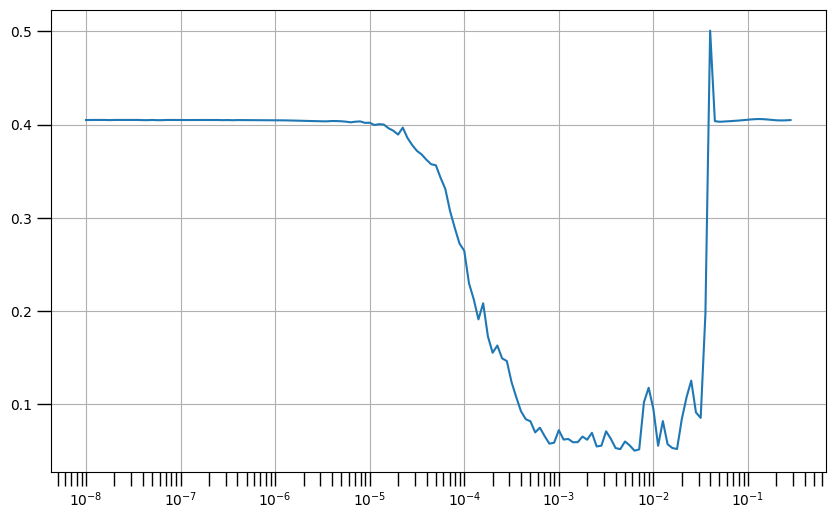

In [58]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(150) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, multivariate_history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 100])

In [59]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
multivariate_model.set_weights(multivariate_init_weights)

In [60]:
# Set the learning rate
learning_rate = 1e-3

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
multivariate_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [61]:
# Train the model
multivariate_history = multivariate_model.fit(multivariate_train_set, epochs=100, validation_data=multivariate_val_set)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3887 - mae: 0.7759 - val_loss: 0.2587 - val_mae: 0.5800
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2907 - mae: 0.6038 - val_loss: 0.1626 - val_mae: 0.4075
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1805 - mae: 0.4304 - val_loss: 0.1049 - val_mae: 0.2962
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1317 - mae: 0.3266 - val_loss: 0.0847 - val_mae: 0.2420
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1096 - mae: 0.2840 - val_loss: 0.0732 - val_mae: 0.2168
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0933 - mae: 0.2549 - val_loss: 0.0640 - val_mae: 0.1975
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0790 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1996
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0659 - mae: 0.2195 - val_loss: 0.0467 - val_mae: 0.1675
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

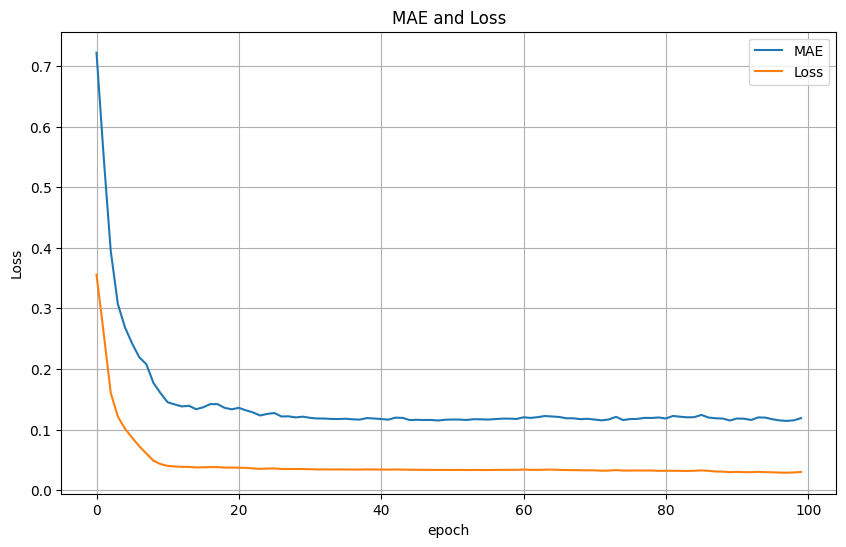

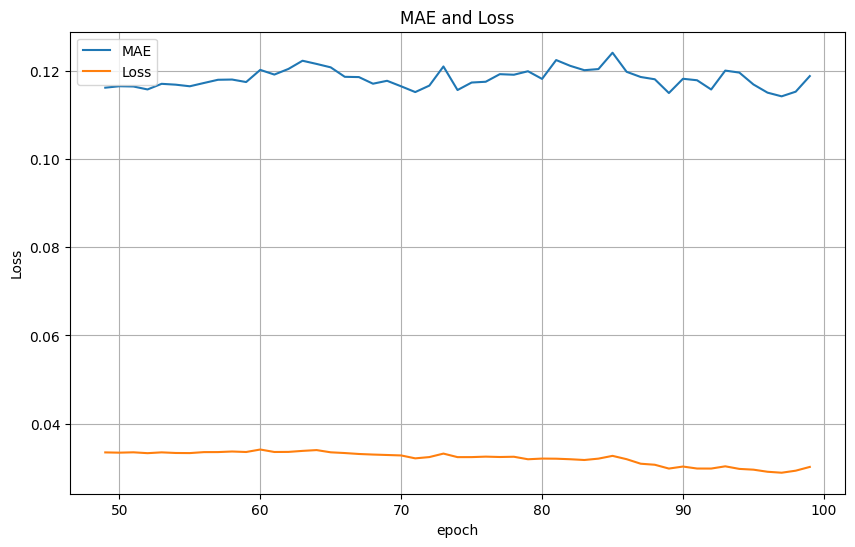

In [62]:
# Get mae and loss from history log
mae = multivariate_history.history['mae']
loss = multivariate_history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 50% of the epochs
zoom_split = int(epochs[-1] * 0.5)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [63]:
def multivariate_model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

### Typical Price

In [ ]:
# Reduce the original series
forecast_data = data_table_standard[train_split-window_size+1:val_split]

# Use helper function to generate predictions
forecast = multivariate_model_forecast(multivariate_model, forecast_data, window_size, batch_size)

forecasted_open_price = (forecast[:,0] * open_price_sd) + open_price_mean
actual_open_price_valid = data_valid[:,0]

# Plot the open price
plot_series(time_valid, (actual_open_price_valid, forecasted_open_price))

### Open Price

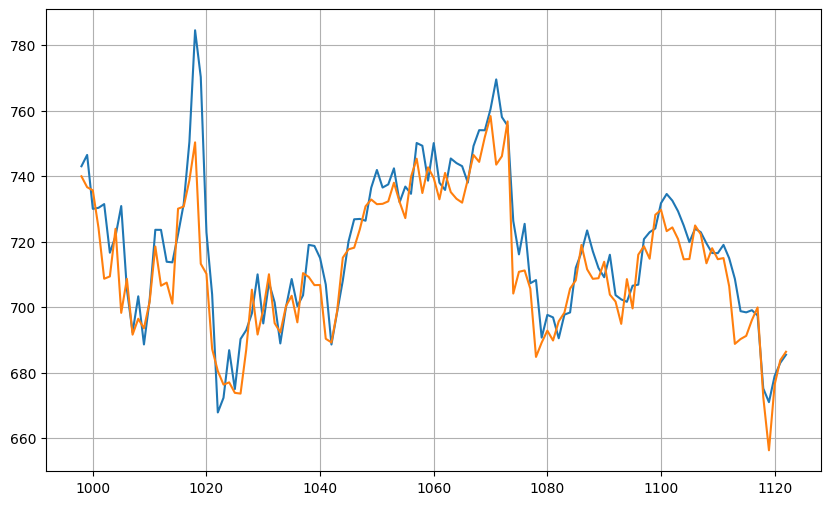

In [64]:
# Reduce the original series
forecast_data = data_table_standard[train_split-window_size+1:val_split]

# Use helper function to generate predictions
forecast = multivariate_model_forecast(multivariate_model, forecast_data, window_size, batch_size)

forecasted_open_price = (forecast[:,0] * open_price_sd) + open_price_mean
actual_open_price_valid = data_valid[:,0]

# Plot the open price
plot_series(time_valid, (actual_open_price_valid, forecasted_open_price))

In [65]:
tf.keras.losses.MAE(actual_open_price_valid, forecasted_open_price).numpy()

7.7213125

### Closing Price

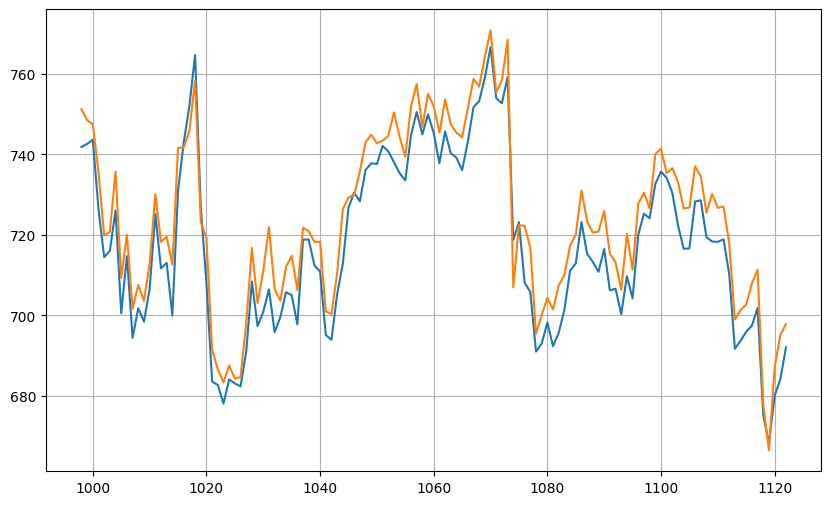

In [66]:
forecasted_close_price = (forecast[:,1] * close_price_sd) + close_price_mean
actual_close_price_valid = data_valid[:,1]

# Plot the open price
# plot_series(time_valid, (actual_open_price_valid, forecasted_open_price))
plot_series(time_valid, (actual_close_price_valid, forecasted_close_price))

In [67]:
tf.keras.losses.MAE(actual_close_price_valid, forecasted_close_price).numpy()

6.885855

### High Price

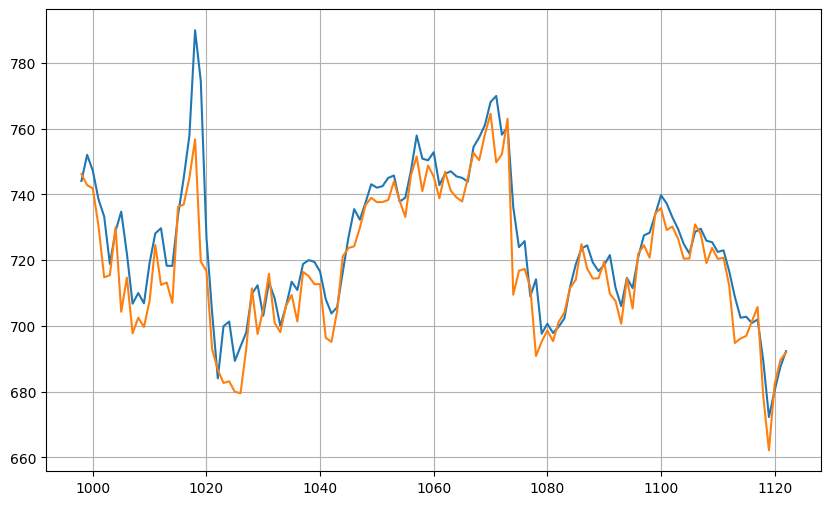

In [68]:
forecasted_high_price = (forecast[:,2] * high_price_sd) + high_price_mean
actual_high_price_valid = data_valid[:,2]

# Plot the open price
# plot_series(time_valid, (actual_open_price_valid, forecasted_open_price))
plot_series(time_valid, (actual_high_price_valid, forecasted_high_price))

In [69]:
tf.keras.losses.MAE(actual_high_price_valid, forecasted_high_price).numpy()

6.617693

### Low Price

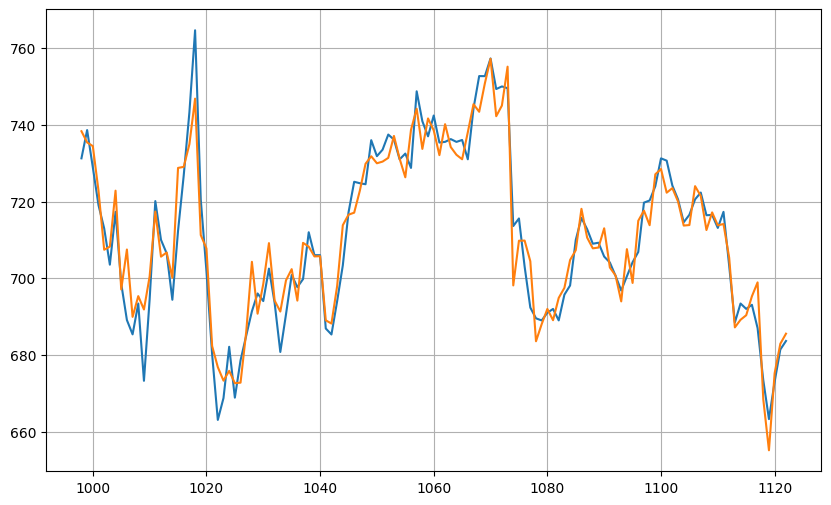

In [70]:
forecasted_low_price = (forecast[:,3] * low_price_sd) + low_price_mean
actual_low_price_valid = data_valid[:,3]

# Plot the open price
# plot_series(time_valid, (actual_open_price_valid, forecasted_open_price))
plot_series(time_valid, (actual_low_price_valid, forecasted_low_price))

In [71]:
tf.keras.losses.MAE(actual_low_price_valid, forecasted_low_price).numpy()

4.7839613

### Volume

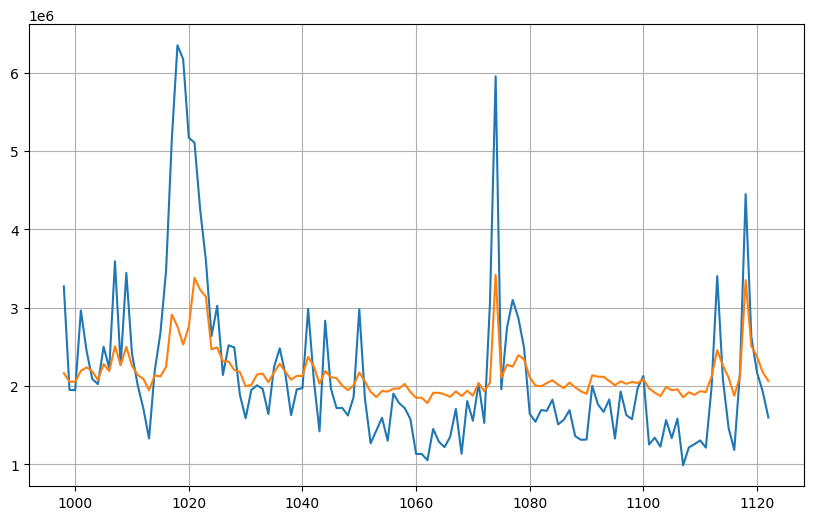

In [72]:
forecasted_volume = (forecast[:,4] * volume_sd) + volume_mean
actual_volume_valid = data_valid[:,4]

# Plot the open price
# plot_series(time_valid, (actual_open_price_valid, forecasted_open_price))
plot_series(time_valid, (actual_volume_valid, forecasted_volume))

In [73]:
tf.keras.losses.MAE(actual_volume_valid, forecasted_volume).numpy()

524978.44

### Open Price

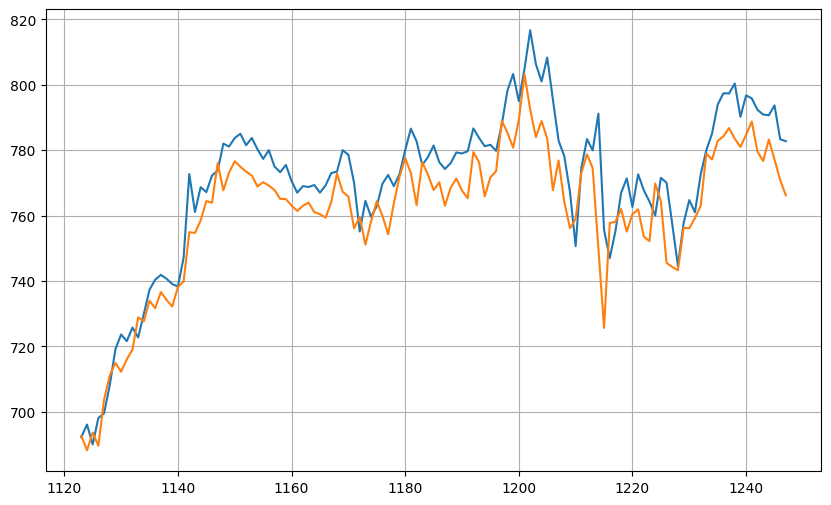

In [74]:
# Reduce the original series
forecast_data = data_table_standard[val_split-window_size+1:]

# Use helper function to generate predictions
forecasted_test = multivariate_model_forecast(multivariate_model, forecast_data, window_size, batch_size)

forecasted_open_price_test = (forecasted_test[:,0] * open_price_sd) + open_price_mean
actual_open_price_test = data_test[:,0]

# Plot the open price
plot_series(time_test, (actual_open_price_test, forecasted_open_price_test))

In [75]:
tf.keras.losses.MAE(actual_open_price_test, forecasted_open_price_test).numpy()

9.393888

### Closing Price

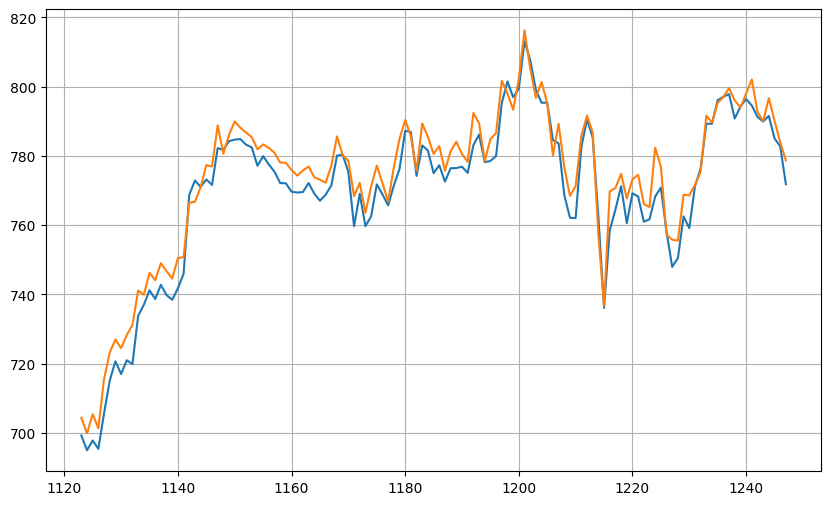

In [76]:
forecasted_close_price_test = (forecasted_test[:,1] * close_price_sd) + close_price_mean
actual_close_price_test = data_test[:,1]

# Plot the open price
plot_series(time_test, (actual_close_price_test, forecasted_close_price_test))

In [77]:
tf.keras.losses.MAE(actual_close_price_test, forecasted_close_price_test).numpy()

4.7132697

### High Price

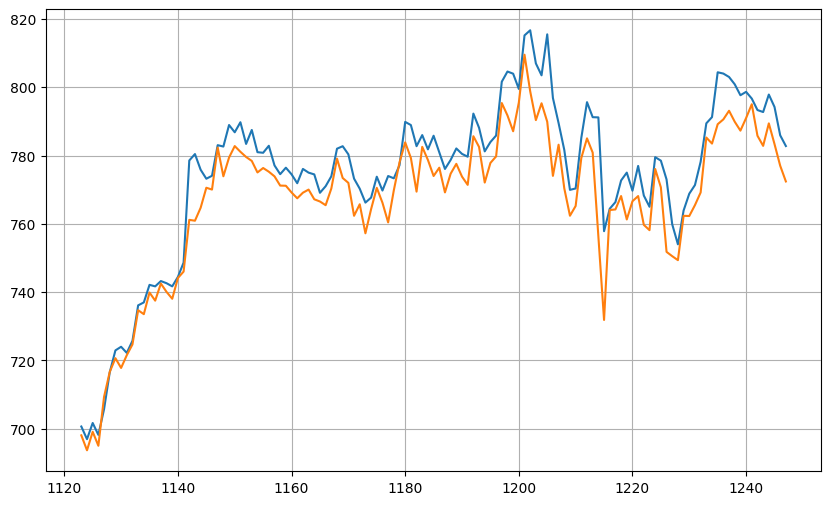

In [78]:
forecasted_high_price_test = (forecasted_test[:,2] * high_price_sd) + high_price_mean
actual_high_price_test = data_test[:,2]

# Plot the open price
plot_series(time_test, (actual_high_price_test, forecasted_high_price_test))

In [79]:
tf.keras.losses.MAE(actual_high_price_test, forecasted_high_price_test).numpy()

7.316379

### Low Price

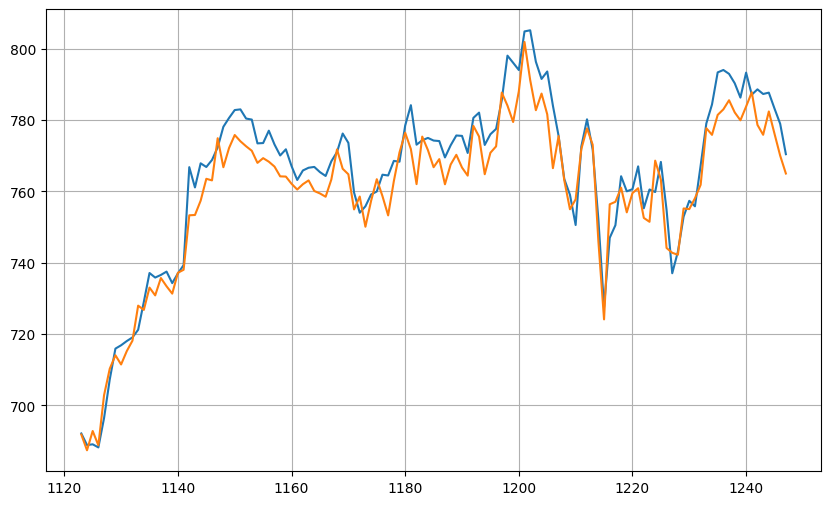

In [80]:
forecasted_low_price_test = (forecasted_test[:,3] * low_price_sd) + low_price_mean
actual_low_price_test = data_test[:,3]

# Plot the open price
plot_series(time_test, (actual_low_price_test, forecasted_low_price_test))

In [81]:
tf.keras.losses.MAE(actual_low_price_test, forecasted_low_price_test).numpy()

5.7888536

### Volume

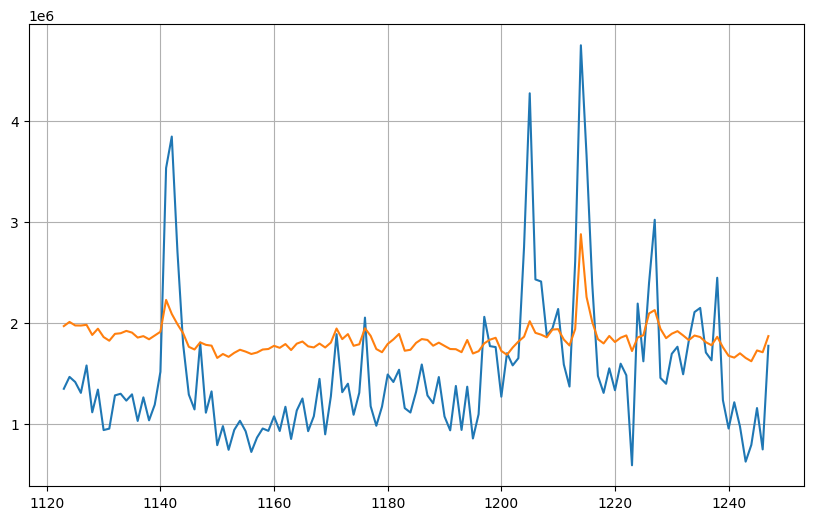

In [82]:
forecasted_volume_test = (forecasted_test[:,4] * volume_sd) + volume_mean
actual_volume_test = data_test[:,4]

# Plot the open price
plot_series(time_test, (actual_volume_test, forecasted_volume_test))

In [83]:
tf.keras.losses.MAE(actual_volume_test, forecasted_volume_test).numpy()

573392.8

# Model 3: Multivariate Analysis using Open, Close, High, Low Prices, Volume, and Treasury Rate to Predict Typical Price

## Split the Dataset

In [84]:
# join t_rate to data standard
data_table = np.hstack(
    (open_price[:, np.newaxis], 
     close_price[:, np.newaxis], 
     high_price[:, np.newaxis], 
     low_price[:, np.newaxis], 
     volume[:, np.newaxis], 
     treasury_rate[:, np.newaxis]))
data_table.shape

(1248, 6)

In [85]:
# Get the train set 
time_train = time_step[:train_split]
data_train = data_table[:train_split]

# Get the validation set
time_valid = time_step[train_split:val_split]
data_valid = data_table[train_split:val_split]

# Get the test set
time_test = time_step[val_split:]
data_test = data_table[val_split:]

print(f"training data size: {data_train.shape}")
print(f"validation data size: {data_valid.shape}")
print(f"testing data size: {data_test.shape}")

training data size: (998, 6)
validation data size: (125, 6)
testing data size: (125, 6)


In [86]:
# standardise training data
t_rate_mean = np.mean(data_train[:,5])
t_rate_sd = np.std(data_train[:,5])

avg_price_mean = np.mean(data_train[:,0])
avg_price_sd = np.std(data_train[:,0])

open_price_mean = np.mean(data_train[:,0])
open_price_sd = np.std(data_train[:,0])

close_price_mean = np.mean(data_train[:,1])
close_price_sd = np.std(data_train[:,1])

high_price_mean = np.mean(data_train[:,2])
high_price_sd = np.std(data_train[:,2])

low_price_mean = np.mean(data_train[:,3])
low_price_sd = np.std(data_train[:,3])

volume_mean = np.mean(data_train[:,4])
volume_sd = np.std(data_train[:,4])

means = np.hstack((open_price_mean, close_price_mean, high_price_mean, low_price_mean, volume_mean, t_rate_mean)).reshape(1,6)
sds = np.hstack((open_price_sd, close_price_sd, high_price_sd, low_price_sd, volume_sd, t_rate_sd)).reshape(1,6)

data_train_standard = (data_train-means)/sds
data_valid_standard = (data_valid-means)/sds
data_test_standard = (data_test-means)/sds
data_table_standard = (data_table-means)/sds

## Prepare Features and Labels

In [87]:
def windowed_dataset_3(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1][:-2]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [88]:
# Generate the training dataset windows
train_set = windowed_dataset_3(data_train_standard, window_size, batch_size, shuffle_buffer_size)

# Generate the validation dataset windows
val_data = data_table_standard[val_split-train_split-window_size:train_split-1]
val_set = windowed_dataset_3(val_data, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [89]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model_3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 6)),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(4)
])

 # Print the model summary 
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       269,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,900 (1.78 MB)

 Trainable params: 466,900 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

In [90]:
# Get initial weights
init_weights_3 = model_3.get_weights()

In [91]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history_3 = model_3.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4139 - learning_rate: 1.0000e-08
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - learning_rate: 1.1220e-08
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - learning_rate: 1.2589e-08
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - learning_rate: 1.4125e-08
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - learning_rate: 1.5849e-08
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - learning_rate: 1.7783e-08
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4139 - learning_rate: 1.9953e-08
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - learning_rate: 2.2387e-08
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4139 - learning_rate: 2.5119e-08
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4139 - learning_rate: 2.8184e-08
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss:

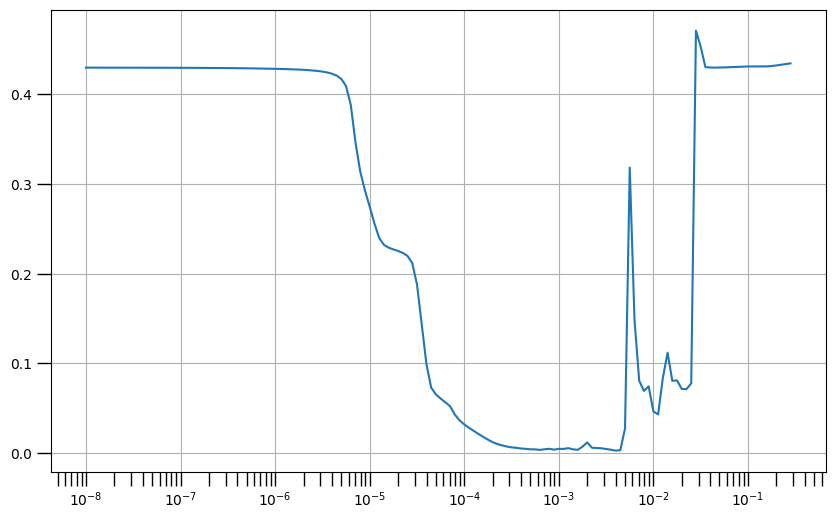

In [92]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(150) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_3.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')


## Training

In [93]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_3.set_weights(init_weights_3)

In [94]:
# Set the learning rate
learning_rate = 3e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model_3.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [95]:
# Train the model
history_3 = model_3.fit(train_set, epochs=150, validation_data=val_set)

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.3899 - mae: 0.7941 - val_loss: 0.2483 - val_mae: 0.5750
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2169 - mae: 0.5254 - val_loss: 0.1746 - val_mae: 0.4402
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1326 - mae: 0.3633 - val_loss: 0.0725 - val_mae: 0.2257
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0640 - mae: 0.2187 - val_loss: 0.0564 - val_mae: 0.2082
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0512 - mae: 0.1950 - val_loss: 0.0466 - val_mae: 0.1864
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0433 - mae: 0.1816 - val_loss: 0.0391 - val_mae: 0.1811
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0341 - mae: 0.1733 - val_loss: 0.0268 - val_mae: 0.1673
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - mae: 0.1610 - val_loss: 0.0204 - val_mae: 0.1449
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

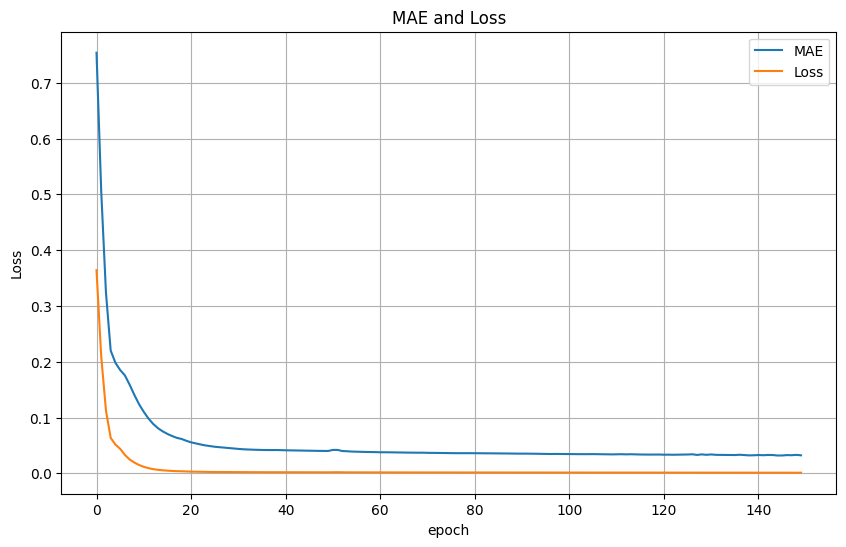

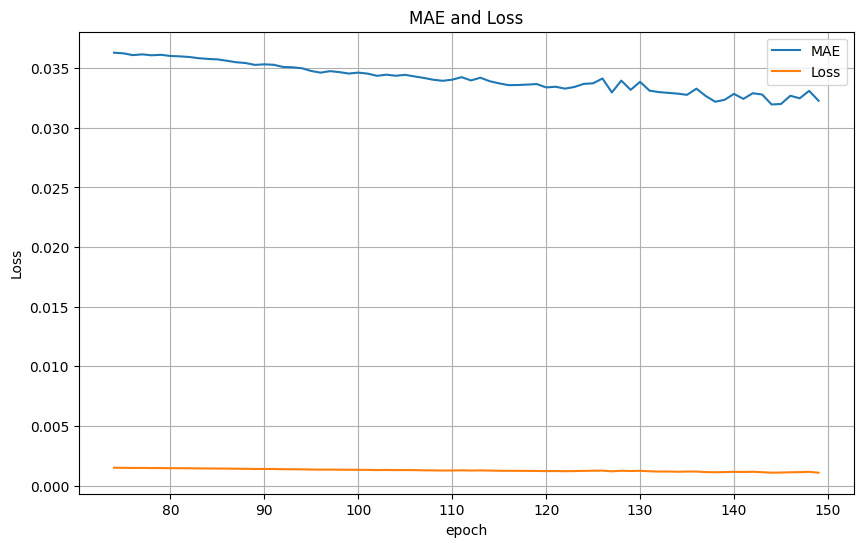

In [96]:
# Get mae and loss from history log
mae = history_3.history['mae']
loss = history_3.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss'], filename="model3_loss"
    )

# Only plot the last 50% of the epochs
zoom_split = int(epochs[-1] * 0.5)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss'], filename="model3_loss_zoom"
    )

## Validation

In [97]:
def model_forecast_3(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

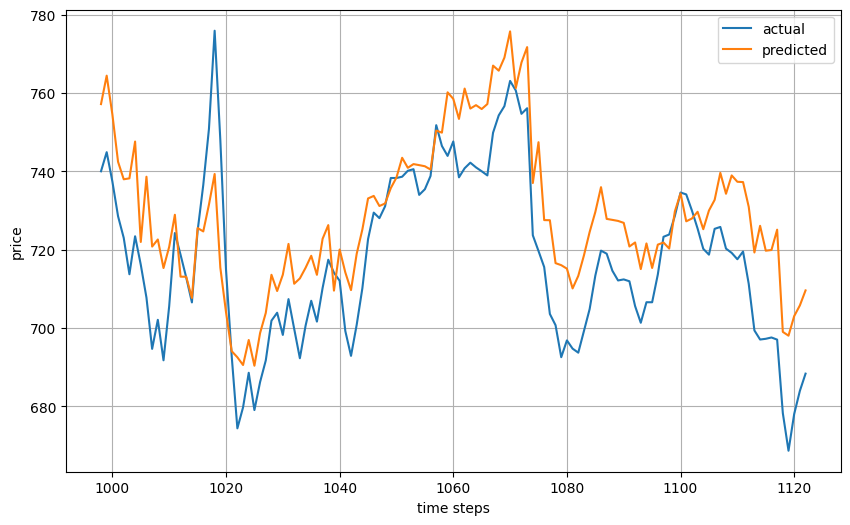

In [98]:
# Reduce the original series
forecast_data = data_table_standard[train_split-window_size+1:val_split]

# Use helper function to generate predictions
forecast = model_forecast_3(model_3, forecast_data, window_size, batch_size)

forecasted_avg_price = (np.mean(forecast[:,:4], axis=1) * avg_price_sd) + avg_price_mean
actual_avg_price_valid = np.mean(data_valid[:,:4], axis=1)

# Plot the open price
plot_series(time_valid, (actual_avg_price_valid, forecasted_avg_price), legend=["actual","predicted"], xlabel="time steps", ylabel="price", filename="model3_output_valid")

In [99]:
tf.keras.losses.MAE(actual_avg_price_valid, forecasted_avg_price).numpy()

13.397631

## Test

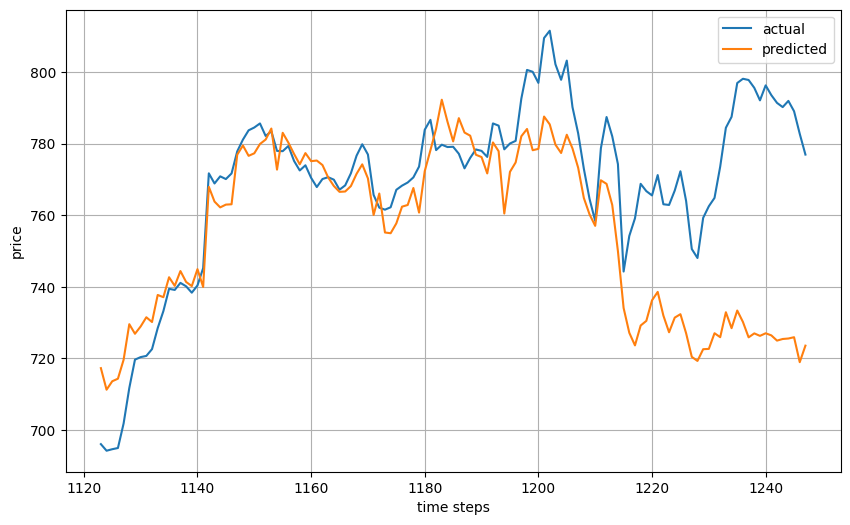

In [109]:
# Reduce the original series
forecast_data = data_table_standard[val_split-window_size+1:]

# Use helper function to generate predictions
forecasted_test = model_forecast_3(model_3, forecast_data, window_size, batch_size)

forecasted_avg_price_test = (np.mean(forecasted_test[:,:4], axis=1) * avg_price_sd) + avg_price_mean
actual_avg_price_test = np.mean(data_test[:,:4], axis=1)

# Plot the open price
plot_series(time_test, (actual_avg_price_test, forecasted_avg_price_test), legend=["actual","predicted"], xlabel="time steps", ylabel="price", filename="model3_output_test")

In [112]:
tf.keras.losses.MAE(actual_avg_price_test, forecasted_avg_price_test).numpy()

18.732273